# Equality constrained analytic centering

<i>minimize</i> $f(x)=-\sum_{i=1}^{n}log(x_i)$ <br>
<i>subject to</i> $Ax=b$ <br>

## Исследование выпуклости задачи

$f(x)$ является суммой функций $-logx_i$
<br><br>
$\frac{d^2}{dx_i^2}(-logx_i) = \frac{1}{x_i^2} > 0$, а значит функция $-logx_i$ - выпуклая. <br>
<br>
Из этого следует что целевая функция $f(x)$ также выпукла так как является суммой выпуклых функций.
Ограничение $Ax=b$ задаёт аффинное множество, которое всегда является выпуклым. Таким образом, задача минимизации является **выпуклой**.

Лагранжиан: <br>
$L(x,λ)=-\sum_{i=1}^{n}(logx_i)+λ^T(Ax-b)$ <br>

Необходимые условия минимума (ККТ): <br>
$\nabla L=-(\frac{1}{x_1},\frac{1}{x_2}, ... ,\frac{1}{x_n})^T+A^Tλ=0 ⇒ A^Tλ=(\frac{1}{x_1},\frac{1}{x_2}, ... ,\frac{1}{x_n})^T$ <br>
$Ax=b$ <br>

В итоге имеем систему: <br>
$\begin{cases}
A^Tλ=diag(x)^{-1}1 \\
Ax=b
\end{cases}$

## Двойственная задача

Определим двойственную функцию как нижнюю границу лагранжиана по переменной $x$:
$g(λ)=\inf\limits_{x > 0} L(x, \lambda)$ <br>
$\nabla L=-(\frac{1}{x_1},\frac{1}{x_2}, ... ,\frac{1}{x_n})^T+A^Tλ=0$ ⇒ рассмотрим условия стационарности ⇒
$\frac{1}{x_i}=(A^Tλ)_i$ ⇒
$x_i=\frac{1}{(A^Tλ)_i}$ <br>

Подставим выраженный $x$ в лагранжиан: <br>
$g(λ)=\sum_{i=1}^{n}(log(A^T\lambda)_i)+\sum_{i=1}^{n}(A^T\lambda_i*\frac{1}{A^T\lambda_i})-\lambda^Tb$ <br>
$g(λ)=\sum_{i=1}^{n}(log(A^T\lambda)_i)+n-\lambda^Tb$

Область допустимых $𝜆$: $(𝐴^𝑇𝜆)_𝑖>0$ для всех $𝑖$, чтобы логарифмы были определены.

Имеем двойственную задачу: <br>
<i>maximize</i> $\sum_{i=1}^{n}(log(A^T\lambda)_i)+n-\lambda^Tb$ <br>

## Импорты

In [1]:
import numpy as np
import cvxpy as cp
from tqdm import tqdm
import time
from scipy.linalg import null_space

## Для каждого значения размерности $n ∈ {10,20,...,100}$ сгенерируйте $N = 100$ тестовых примеров В каждом случае найдите глобальный минимум, $x^* ∈ R^n$, с помощью CVX

In [203]:
rseed = 45
np.random.seed(rseed)

def generate_problem(n, seed=None):
    """
    Генерирует задачу для оптимизации.

    Параметры:
    ----------
    n: Размерность искомого вектора x ∈ ℝⁿ.
    seed: Значение для инициализации генератора случайных чисел (для воспроизводимости).

    Возвращает:
    -----------
    A: Матрица ограничений, с m = floor(n / 5) строк.
    b: Вектор правой части, вычисленный как b = A @ x_true.
    x_true: Генерируемая допустимая точка (гарантированно положительная).
    """

    rng = np.random.default_rng(seed)

    """
    Размерность m выбирается как n // 5, чтобы гарантировать наличие ненулевого ядра у A (m < n),
    что важно при генерации допустимых начальных точек через сдвиг вдоль ядра A.
    """
    m = n // 5
    A = rng.uniform(0, 100, size=(m, n))  # случайная матрица A ∈ ℝ^(m×n)

    x_true = rng.uniform(0.1, 50.0, size=n)  # гарантированно x_i > 0
    b = A @ x_true  # правая часть системы Ax = b

    return A, b, x_true


def solve_problem(A, b):
    """
    Решает задачу выпуклой оптимизации.

    Параметры:
    ----------
    A: Матрица линейных ограничений.
    b: Правая часть системы ограничений A x = b.

    Возвращает:
    -----------
    x_opt: Оптимальное решение x*, если найдено. Иначе — None.
    f_opt: Оптимальное значение целевой функции f(x*) = -∑ log(x_i). Иначе — None
    """

    n = A.shape[1]
    x = cp.Variable(n)

    # Целевая функция: максимизировать сумму логарифмов
    objective = cp.Minimize(-cp.sum(cp.log(x)))

    # Ограничения: линейная система A x = b
    constraints = [A @ x == b]

    # Определяем и решаем задачу
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # Обработка случая, если задача не имеет допустимого решения
    if prob.status in ["infeasible", "unbounded"]:
        return None, None

    return x.value, prob.value

In [204]:
# Размерности задач
dimensions = range(10, 101, 10)

# Число задач на каждую размерность
N = 100

a_generated = {n_val:[] for n_val in dimensions} # Список матриц A для каждой размерности
b_generated = {n_val:[] for n_val in dimensions} # Список векторов b
x_true_generated = {n_val:[] for n_val in dimensions} # Истинные допустимые решения (для генерации b)
cvx_opts = {n_val:[] for n_val in dimensions} # Оптимальные значения f(x*) через CVXPY
cvx_time = {n_val:[] for n_val in dimensions}  # Время решения каждой задачи

for n in dimensions:
    for _ in tqdm(range(N), desc=f"Processing N = {n}"):
        # 1. Генерация задачи: A, b, x_true (гарантированно x_true > 0, b = A @ x_true)
        A, b, x_true = generate_problem(n)

        # 2. Решение через CVXPY + замер времени
        start_time = time.time()
        x_star, min_value = solve_problem(A, b)
        elapsed_time = time.time() - start_time

        # 3. Проверка на корректность решения
        if x_star is None:
            print("The problem is infeasible or unbounded.")
            continue

        # 4. Сохраняем результаты
        a_generated[n].append(A)
        b_generated[n].append(b)
        x_true_generated[n].append(x_true)
        cvx_opts[n].append(min_value)
        cvx_time[n].append(elapsed_time)

print("\nDone")

Processing N = 100: 100%|██████████| 100/100 [00:01<00:00, 68.96it/s]


Done


# Для каждого значения $n ∈ {10,20,...,100}$ и для каждого тестового примера сгенерируйте 100 начальных точек. Для за данной точности по значению функции $ε = 0.01$ решите задачу с помощью прямого и двойственного метода Ньютона (стандартный метод Ньютона для решения двойственной задачи). Приведите необходимые аналитические вычисления.

**<h1>Прямая задача, метод Ньютона</h1>**

In [205]:
def primal_obj(x):
    """
    Целевая функция f(x) = -∑ log(x_i).
    Предполагается, что все компоненты x_i > 0.
    """
    return -np.sum(np.log(x))

def primal_grad(x):
    """
    Градиент ∇f(x) = -1/x.
    Возвращает вектор размерности (n,).
    """
    return -1.0 / x

def primal_hess(x):
    """
    Гессиан ∇²f(x) = diag(1 / x^2).
    Возвращает диагональную матрицу размера (n×n).
    """
    return np.diag(1.0 / (x**2))

In [206]:
def solve_primal_newton(x_init, A, b, f_opt, max_iters=1000, eps=1e-2, return_history=False):
    """
    Прямой метод Ньютона для задачи.

    Параметры:
    -----------
      x_init: Начальная точка, удовлетворя A x_init = b, x_init > 0.
      A, b: Данные задачи: A (m×n), b (m,).
      f_opt: Известное оптимальное значение f(x*).
      max_iters: Максимально допустимое число итераций метода.
      eps: Требуемая точность по функции: |f(x) - f_opt| < eps.
      return_history: Возвращать ли историю ошибок (|f(x) - f_opt|) по итерациям.

    Возвращает:
    -----------
      x: Найденное решение.
      f_val: Значение f(x) на полученном решении.
      err:  Итоговая погрешность |f_val - f_opt|.
      iters: Число фактически выполненных итераций (<= max_iters).
      history: История ошибки (|f(x_k) - f_opt|) по итерациям, если return_history=True.
    """

    # Делаем копию x_init
    x = x_init.copy()

    # Определяем размерность
    n, m = x.size, A.shape[0]

    # Начальное значение ошибки
    prec_history = []
    current_err = abs(primal_obj(x) - f_opt)
    prec_history.append(current_err)

    # Параметры для backtracking line search (из книги)
    alpha = 0.1
    beta = 0.5

    for k in range(max_iters):
        # 1) Вычисляем градиент и гессиан
        grad = primal_grad(x)
        hess = primal_hess(x)

        # 2) Формируем KKT-систему
        KKT = np.block([
            [hess, A.T],
            [A,    np.zeros((m, m))]
        ])
        rhs = np.hstack([-grad, np.zeros(m)])

        # 3) Решаем KKT
        sol = np.linalg.solve(KKT, rhs)
        dx = sol[:n]

        # 4) Backtracking line search
        f_val = primal_obj(x)
        gdx = grad @ dx # скалярное произведение grad(x) · dx

        t = 1.0
        success = False
        for _ in range(20):
            x_new = x + t*dx

            # Проверяем, что остаёмся в области x > 0
            if np.all(x_new > 0):
                f_new = primal_obj(x_new)
                if f_new <= f_val + alpha * t * gdx:
                    success = True
                    break
            t *= beta

        # Если ни один шаг не подошёл — останавливаемся
        if not success:
            break

        # Обновляем x
        x = x_new

        # 5) Считаем новую ошибку
        current_err = abs(primal_obj(x) - f_opt)
        if return_history:
            prec_history.append(current_err)

        # 6) Проверяем достижение требуемой точности
        if current_err < eps:
            break

    if return_history:
        return x, primal_obj(x), current_err, k + 1, prec_history
    else:
        return x, primal_obj(x), current_err, k + 1

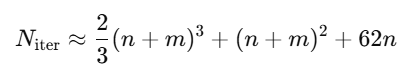

In [207]:
def generate_newton_starts(A: np.ndarray,
                           x_true: np.ndarray,
                           num_starts: int = 5,
                           alpha_max: float = 1000,
                           seed: int = None) -> np.ndarray:
    """
    Генерирует начальные точки для метода Ньютона.

    Параметры:
    -----------
    A: Матрица линейных ограничений, предполагается m < n (ядро ненулевое).
    x_true: Допустимая точка, такая что A @ x_true = b и x_true > 0.
    num_starts:  Сколько начальных точек сгенерировать.
    alpha_max:  Верхняя граница для случайного коэффициента alpha.
    seed: Значение для генератора случайных чисел (для воспроизводимости).

    Возвращает:
    -----------
    starts:  Массив начальных точек x_start, пригодных для запуска метода Ньютона. Каждая из них удовлетворяет A x = b и x > 0.

    Исключения:
    -----------
    ValueError: Если ядро матрицы A пусто (m ≥ n), генерация невозможна.

    Примечание:
    -----------
    Генерация основана на сдвиге вдоль базиса ядра A: поскольку A @ k = 0, то A @ (x_true + α * k) = A @ x_true = b — сохраняется допустимость.
    x_start = x_true + α * k,
    где:
      - k — случайный вектор из ядра матрицы A (k ∈ ker(A)),
      - α ~ Uniform(0, alpha_max),
      - x_start > 0 — компонентно положительный.

    """
    rng = np.random.default_rng(seed)

    # Находим базис ядра матрицы A (размерность r = n - rank(A))
    U = null_space(A)  # U.shape = (n, r)
    if U.shape[1] == 0:
        raise ValueError("У матрицы A нет ненулевого ядра. Требуется m < n.")

    starts = []

    while len(starts) < num_starts:
        # Выбираем случайный вектор из базиса ядра
        j = rng.integers(U.shape[1])
        k = U[:, j]  # k ∈ ker(A)

        # Случайное масштабирование вдоль направления ядра
        alpha = rng.uniform(0, alpha_max)

        # Сдвигаем x_true вдоль направления ядра
        x_candidate = x_true + alpha * k

        # Проверка: все компоненты должны остаться положительными
        if np.all(x_candidate > 0):
            starts.append(x_candidate)

    return np.array(starts)

In [208]:
newton_opts  = {n: [] for n in dimensions}  # Средние значения f(x*) для каждой размерности
newton_eps   = {n: [] for n in dimensions}  # Средние ошибки |f(x) - f_opt|
newton_time  = {n: [] for n in dimensions}  # Среднее время (сек) на одну точку
newton_iters = {n: [] for n in dimensions}  # Среднее число итераций
data_for_graph = {}                         # Подробные результаты для анализа

for n in dimensions:
    data_for_graph[n] = {}
    print(f"Processing n = {n}")

    for i in tqdm(range(N)):
        data_for_graph[n][i] = {}

        # --- Заранее сгенерированные данные ---
        A = a_generated[n][i]
        b = b_generated[n][i]
        x_true = x_true_generated[n][i]
        cvx_opt = cvx_opts[n][i]

        # --- Генерация N допустимых стартов x_init ---
        x_inits = generate_newton_starts(A, x_true, num_starts=N, alpha_max=1000, seed=rseed)

        num_iter = 0
        total_eps = 0
        total_min_value = 0

        # --- Запускаем метод Ньютона для каждого старта ---
        start_time = time.time()

        for idx, x in enumerate(x_inits):
            x_star, min_value, eps, iters = solve_primal_newton(x, A, b, cvx_opt)
            num_iter += iters
            total_eps += eps
            total_min_value += min_value

            data_for_graph[n][i][idx] = {
                'iter': iters,
                'eps': eps,
                'min_value': min_value
            }

        elapsed_time = time.time() - start_time

        # --- Сохраняем среднюю статистику по задаче ---
        newton_time[n].append(elapsed_time / N)
        newton_iters[n].append(num_iter / N)
        newton_eps[n].append(total_eps / N)
        newton_opts[n].append(total_min_value / N)


Processing n = 10


100%|██████████| 100/100 [00:11<00:00,  8.73it/s]


Processing n = 20


100%|██████████| 100/100 [00:13<00:00,  7.44it/s]


Processing n = 30


100%|██████████| 100/100 [00:17<00:00,  5.75it/s]


Processing n = 40


100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


Processing n = 50


100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


Processing n = 60


100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


Processing n = 70


100%|██████████| 100/100 [00:24<00:00,  4.09it/s]


Processing n = 80


100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Processing n = 90


100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Processing n = 100


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


**<h1>Двойственная задача, метод Ньютона</h1>**

In [209]:
def random_feasible_nu(A, seed=None):
    """
    Генерирует допустимую точку nu для двойственной задачи.

    Идея:
    -----
    Вместо случайного поиска nu с A^T nu > 0, явно решаем уравнение: A^T @ nu = c · 1, где 1 — вектор из единиц длины n, а c > 0 — случайная положительная константа.
    Так как правая часть строго положительна, решение гарантирует допустимость: A^T @ nu = c · 1 > 0  ⇒  допустимая точка для двойственной задачи.

    Параметры:
    ----------
    A: Матрица ограничений (из прямой задачи).
    seed: Сид для генератора случайных чисел (обеспечивает воспроизводимость).

    Возвращает:
    -----------
    nu: Допустимая точка nu, такая что A^T @ nu > 0.
    """
    rng = np.random.default_rng(seed)

    # Случайная положительная константа c ∈ [0.1, 2.0]
    c = rng.uniform(0.1, 2.0)

    # Правая часть — строго положительный вектор
    ones_n = np.ones(A.shape[1])

    # Решаем систему A^T @ nu = c * 1
    # Используем наименьшие квадраты, так как A^T может быть не квадратной
    nu, *_ = np.linalg.lstsq(A.T, c * ones_n, rcond=None)
    return nu

In [210]:
def dual_grad(nu, A, b):
  """
  Вычисляет градиент двойственной функции.
  """
  inv_ATnu = 1.0 / (A.T @ nu)
  return A @ inv_ATnu - b

def dual_hess(nu, A):
  """
  Вычисляет гессиан двойственной функции.
  """
  inv_ATnu_sq = 1.0 / (A.T @ nu)**2
  return -A @ np.diag(inv_ATnu_sq) @ A.T

def dual_obj_func(nu, A, b):
    """
    Вычисляет значение двойственной функции.
    """
    ATnu = A.T @ nu
    if np.any(ATnu <= 0):
        return -np.inf  # Возвращаем -∞ для недопустимых точек
    return np.sum(np.log(ATnu)) - b.T @ nu + len(ATnu)

In [211]:
def solve_dual_newton(nu_init, A, b, cvx_opt, max_iters=1000, eps=1e-2, return_history=False):
  """
  Решает двойственную задачу методом Ньютона.

  Параметры:
  ----------
  nu_init: Начальная допустимая точка ν₀ (A^T ν > 0).
  A: Матрица ограничений прямой задачи.
  b: Правая часть ограничений.
  cvx_opt: Точное значение решения, полученное через CVX (для оценки ошибки).
  max_iters: Максимум итераций метода.
  eps: Требуемая точность |g(ν) - f_opt| < eps.
  return_history: Если True, возвращает историю ошибки по итерациям.

  Возвращает:
  -----------
  nu: найденное ν (dual переменная)
  g_nu: значение двойственной функции g(ν)
  precision: текущая ошибка по цели
  iters: число выполненных итераций
  history: список ошибок, если return_history=True
  """
  m = A.shape[0]
  nu = nu_init.copy()
  prev_obj = -np.inf
  I = np.eye(m)
  prec_history = [abs(dual_obj_func(nu, A, b) - cvx_opt)]

  for iter in range(max_iters):
    try:
      # Шаг 1. Вычисляем A^T ν один раз за итерацию
      ATnu = A.T @ nu # 2n^2 - n операций

      # Проверяем допустимость точки: все компоненты A^T ν должны быть строго положительными
      if np.any(ATnu <= 0):
          raise ValueError("Недопустимая точка")

      # Шаг 2. Вычисляем градиент и гессиан
      inv_ATnu = 1.0 / ATnu # n операций
      grad = A @ inv_ATnu - b # 2n^2 операций
      inv_ATnu_sq = inv_ATnu**2 # n операций
      hess = -A @ (inv_ATnu_sq.reshape(-1, 1) * A.T) # 2n^3 - n^2 операций

      # Шаг 3. Решаем систему H δν = -∇g(ν)
      KKT = hess + 1e-8 * I # Добавляем малую регуляризацию εI для численной устойчивости - n операций
      dnu = np.linalg.solve(KKT, -grad) # Находим направление поиска δν - (2/3)n^3 + 2n^2 операций

      # Шаг 4. Линейный поиск (Backtracking line search) - максимум 40n^2 + 20n - 20 операций
      t = 1.0
      for _ in range(20):
          new_nu = nu + t * dnu
          new_ATnu = A.T @ new_nu
          if np.all(new_ATnu > 0):
              new_obj = np.sum(np.log(new_ATnu)) - b.T @ new_nu + len(new_ATnu)
              if iter == 0 or new_obj > prev_obj + 1e-8:
                break
          t *= 0.5

      # Шаг 5. Обновление состояния
      nu = new_nu
      prev_obj = new_obj

      precision = abs(dual_obj_func(nu, A, b) - cvx_opt)

      if return_history:
          prec_history.append(precision)

      # Критерий останова по цели
      if precision < eps:
          break

    except Exception as e:
      print(f"Error on iteration: {iter}: {str(e)}")
      break

  # Шаг 6. Восстановление прямого решения
  ATnu = A.T @ nu
  x = 1.0 / ATnu if np.all(ATnu > 0) else np.full(A.shape[1], np.nan)

  # Если мы не достигли нужной точности
  if precision > eps:
      print('Iterations limit exceeded')

  if return_history:
      return nu, dual_obj_func(nu, A, b), precision if np.all(ATnu > 0) else np.inf, iter+1, prec_history

  return nu, dual_obj_func(nu, A, b), precision if np.all(ATnu > 0) else np.inf, iter+1

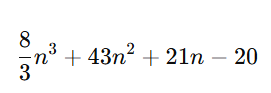

In [212]:
newton_opts_dual  = {n: [] for n in dimensions}   # Средние значения двойственной функции
newton_eps_dual   = {n: [] for n in dimensions}   # Средняя ошибка |g(ν) - f_opt|
newton_time_dual  = {n: [] for n in dimensions}   # Среднее время на одну итерацию
newton_iters_dual = {n: [] for n in dimensions}   # Среднее число итераций до сходимости
data_for_graph_dual = {}                          # Полные данные по всем запускам

for n in dimensions:
    data_for_graph_dual[n] = {}
    print(f"Processing n = {n}")

    for i in tqdm(range(N)):
        data_for_graph_dual[n][i] = {}

        # --- Заранее сгенерированные данные ---
        A = a_generated[n][i]
        b = b_generated[n][i]
        cvx_opt = cvx_opts[n][i]

        # Генерация N допустимых начальных точек ν
        nu_inits = [random_feasible_nu(A, rseed) for _ in range(N)]

        num_iter = 0
        total_eps = 0
        total_min_value = 0

        # --- Запускаем метод Ньютона для каждого старта ---
        start_time = time.time()

        for idx, nu_init in enumerate(nu_inits):
            nu_star, min_value, eps, iters = solve_dual_newton(nu_init, A, b, cvx_opt)
            num_iter += iters
            total_eps += eps
            total_min_value += min_value

            data_for_graph_dual[n][i][idx] = {
                'iter': iters,
                'eps': eps,
                'min_value': min_value
            }

        elapsed_time = time.time() - start_time

        # --- Сохраняем среднюю статистику по задаче --
        newton_time_dual[n].append(elapsed_time / N)
        newton_iters_dual[n].append(num_iter / N)
        newton_eps_dual[n].append(total_eps / N)
        newton_opts_dual[n].append(total_min_value / N)


Processing n = 10


100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


Processing n = 20


100%|██████████| 100/100 [00:08<00:00, 12.01it/s]


Processing n = 30


100%|██████████| 100/100 [00:08<00:00, 11.34it/s]


Processing n = 40


100%|██████████| 100/100 [00:08<00:00, 12.27it/s]


Processing n = 50


100%|██████████| 100/100 [00:09<00:00, 10.25it/s]


Processing n = 60


100%|██████████| 100/100 [00:10<00:00,  9.77it/s]


Processing n = 70


100%|██████████| 100/100 [00:10<00:00,  9.43it/s]


Processing n = 80


100%|██████████| 100/100 [00:10<00:00,  9.67it/s]


Processing n = 90


100%|██████████| 100/100 [00:11<00:00,  8.83it/s]


Processing n = 100


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


**<h1>Время работы и среднее число итераций</h1>**

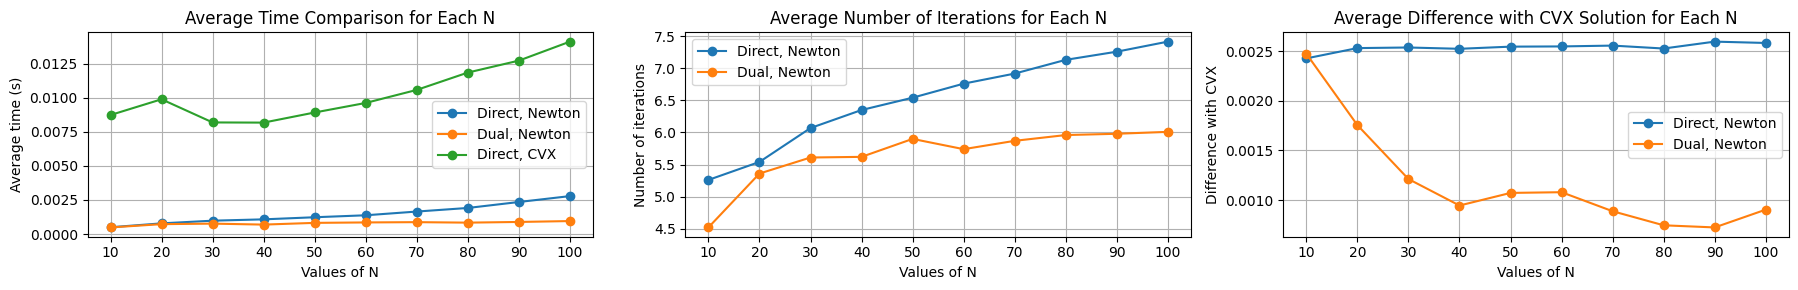

In [213]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(1, 3, figsize=(18, 3))
axes[0].plot(dimensions, [sum(newton_time[n])/len(newton_time[n]) for n in dimensions], label='Direct, Newton', marker='o', linestyle='-')
axes[0].plot(dimensions, [sum(newton_time_dual[n])/len(newton_time_dual[n]) for n in dimensions], label='Dual, Newton', marker='o', linestyle='-')
axes[0].plot(dimensions, [sum(cvx_time[n])/len(cvx_time[n]) for n in dimensions], label='Direct, CVX', marker='o', linestyle='-')
axes[0].set_xlabel('Values of N')
axes[0].set_ylabel('Average time (s)')
axes[0].set_title('Average Time Comparison for Each N')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(dimensions)

axes[1].plot(dimensions, [sum(newton_iters[n])/len(newton_iters[n]) for n in dimensions], label='Direct, Newton', marker='o', linestyle='-')
axes[1].plot(dimensions, [sum(newton_iters_dual[n])/len(newton_iters_dual[n]) for n in dimensions], label='Dual, Newton', marker='o', linestyle='-')
axes[1].set_xlabel('Values of N')
axes[1].set_ylabel('Number of iterations')
axes[1].set_title('Average Number of Iterations for Each N')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xticks(dimensions)

axes[2].plot(dimensions, [sum(newton_eps[n])/len(newton_eps[n]) for n in dimensions], label='Direct, Newton', marker='o', linestyle='-')
axes[2].plot(dimensions, [sum(newton_eps_dual[n])/len(newton_eps_dual[n]) for n in dimensions], label='Dual, Newton', marker='o', linestyle='-')
axes[2].set_xlabel('Values of N')
axes[2].set_ylabel('Difference with CVX')
axes[2].set_title('Average Difference with CVX Solution for Each N')
axes[2].legend()
axes[2].grid(True)
axes[2].set_xticks(dimensions)

plt.tight_layout()
plt.show()

**<h1>Зависимость точности от числа итераций</h1>**

In [214]:
A, b, x_true = generate_problem(n, 42)
cvx_x, cvx_opt = solve_problem(A, b)

n_start_points = 5
primal_precs = []
x_inits = generate_newton_starts(A, x_true, num_starts=n_start_points, alpha_max=1000, seed=rseed)
for idx, x in enumerate(x_inits):
      x_star, min_value, eps, iters, primal_prec = solve_primal_newton(x, A, b, cvx_opt, return_history=True)
      primal_precs.append(primal_prec)

dual_precs = []
for _ in range(n_start_points):
      nu_init = random_feasible_nu(A)
      nu_star, min_value, eps, iters, dual_prec = solve_dual_newton(nu_init, A, b, cvx_opt, return_history=True)
      dual_precs.append(dual_prec)

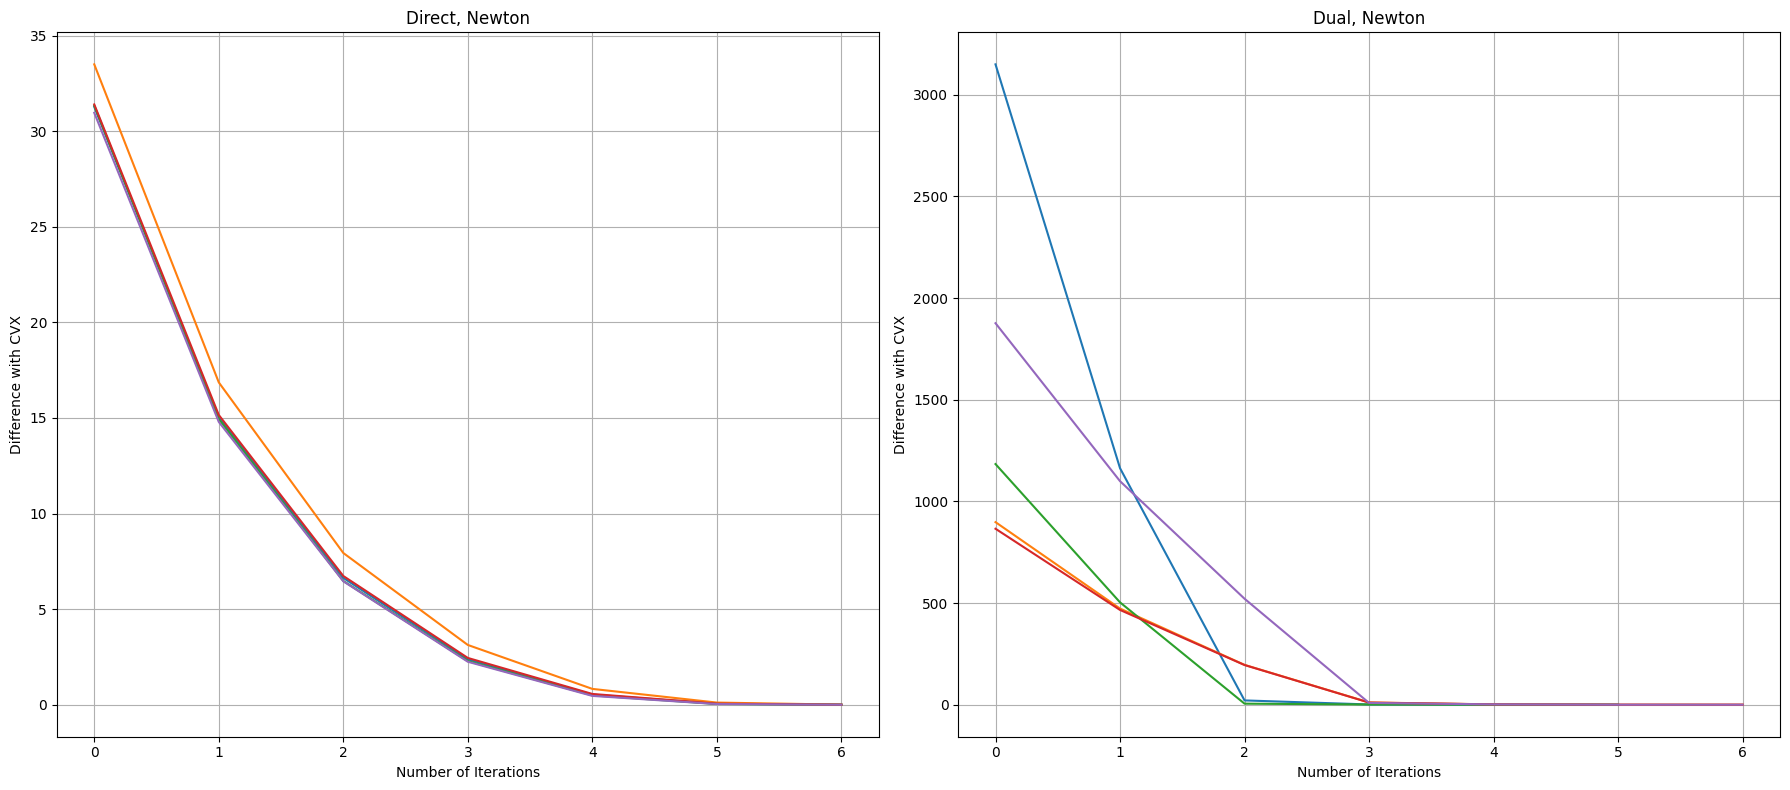

In [215]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
for primal in primal_precs:
    axes[0].plot(range(len(primal)), primal)
axes[0].set_xlabel('Number of Iterations')
axes[0].set_ylabel('Difference with CVX')
axes[0].set_title('Direct, Newton')
axes[0].grid(True)

for dual in dual_precs:
    axes[1].plot(range(len(dual)), dual)
axes[1].set_xlabel('Number of Iterations')
axes[1].set_ylabel('Difference with CVX')
axes[1].set_title('Dual, Newton')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Выводы по сравнению прямого и двойственного методов Ньютона
### 1. Сравнение по времени работы
- Двойственный метод Ньютона является самым быстрым: его время почти не растёт с размерностью, и он стабильно обгоняет как прямой метод, так и CVX.
- Прямой метод Ньютона работает в 2–3 раза медленнее двойственного, но остаётся значительно быстрее стандартного CVX-решателя.
- Решение через CVX — самый медленный вариант: уже при n = 30 он уступает по времени на порядок.

На практике для всех n двойственный метод достигает результата быстрее всех.

### 2. Число итераций
- Двойственный метод Ньютона в среднем требует ~6 итераций — что полностью совпадает с теорией.
- Прямой метод Ньютона требует в среднем 5.3 – 7.3 итерации и демонстрирует монотонный рост числа итераций с размерностью n.

В книге для прямого метода указывается в среднем от 14 итераций и в 2 раза больше время работы, чем у двойственного метода. У результаты прямого метода лучше, это связано с более удачным выбором стартов для прямой задачи, чем в дуальном методе (исходя из точности к итерациям).

### 3. Точность приближения (разница с CVX)
- Точность прямого метода Ньютона практически постоянна: около 0.0025 для всех размерностей. Это говорит о том, что он быстро достигает области окрестности оптимума, но не улучшается с ростом размерности.

- Двойственный метод Ньютона показывает значительно лучшую сходимость по точности с ростом n: от 0.0024 при n=10 до 0.0008 при n = 90.

При равном числе итераций двойственный метод в среднем восстанавливает точное решение лучше, особенно при больших размерностях.

